# MICCoM School 2022 Ex#2 : Parallelization

## 2.1 : Parallelization levels in WEST

We are going to explain the multilevel parallelization strategy implemented in WEST. When running `wstat.x` and `wfreq.x`, several levels of [MPI](https://en.wikipedia.org/wiki/Message_Passing_Interface) and [OpenMP](https://www.openmp.org) parallelization may be utilized to accelerate the calculation, by distributing the workload across processors:

- `world`: The group of all MPI processes.
- `image`: `world` can be partitioned into `images`. When using the projective dielectric eigendecomposition (PDEP) technique to compute the static dielectric screening, perturbations are distributed across images. Each image is responsible for computing the density response only for the perturbations owned by the image.
- `pool`: Each `image` can be partitioned into `pools`, each working on a subgroup of k-points and spin channels.
- `bgrp`: Each `pool` can be partitioned into `band groups`, each working on a subgroup of bands (wavefunctions).
- `R&G`: Wavefunctions in the plane-wave basis set, as well as density in either real (R) or reciprocal (G) space, are distributed across MPI processes. Fast Fourier transform (FFT) is used to transform quantities between R space and G space. By default, a 3D FFT is parallelized by distributing planes of the 3D grid in real space to MPI processes. In reciprocal space, the G-vectors are distributed.
- `SIMT`: (*used only if GPUs are available*) Each MPI process in a band group is capable of offloading computations to a GPU device using the single instruction, multiple threads (SIMT) protocol.

<img src="https://pubs.acs.org/cms/10.1021/acs.jctc.2c00241/asset/images/large/ct2c00241_0002.jpeg" width="90%">

In this figure, the multilevel parallelization of WEST is exemplified for the case of 16 total MPI processes. The processes are divided into two images. Each image is divided into two pools, each of which is further divided into two band groups. Within each band group there are two MPI processes, each of which is connected to a GPU device.

For more information about the implementation, the reader is referred to [J. Chem. Theory Comput. 11, 2680 (2015)](https://doi.org/10.1021/ct500958p) and [J. Chem. Theory Comput. 18, 4690-4707 (2022)](https://doi.org/10.1021/acs.jctc.2c00241).

## 2.2 : Run WEST in parallel


`wstat.x` and `wfreq.x` support image parallelization, pool parallelization for spin channels (currently not for k-points), band parallelization, and R&G parallelization. The following command is using `N` MPI processes, `NI` images, `NK` pools, `NB` band groups, and `N/(NI*NK*NB)` cores per FFT:

```
mpirun -n N wstat.x -nimage NI -npool NK -nbgrp NB -i wstat.in > wstat.out
```

Or equivalently

```
mpirun -n N wstat.x -ni NI -nk NK -nb NB -i wstat.in > wstat.out
```

Some remarks:

- If any parallelization flag is NOT given, it is the same as setting the corresponding flag to 1, for instance: `mpirun -n 2 wstat.x -i wstat.in > wstat.out` is the same as: `mpirun -n 2 wstat.x -ni 1 -nk 1 -nb 1 -i wstat.in > wstat.out`. This implies that if no parallelization flag is specified, WEST by default only uses the R&G level of parallelization.
- The `R&G` parallelization level helps reduce memory footprint (per MPI process), as each process only stores a fraction of the wavefunctions.
- The amount of data exchange is *low* for `image` and `pool`, *mild* for `bgrp`, and *high* for `R&G`, as the parallel FFT algorithm is known to require all-to-all communications, that is, every MPI process within the same band group must exchange data with every other process. Therefore, lowest walltimes are obtained using the least number of cores per band group.

WEST achieved good scaling on CPU-based and GPU-based supercomputers, such as the Mira supercomputer at Argonne National Laboratory where the code makes efficient use of up to **524,288 CPU cores**, and the Summit supercomputer at Oak Ridge National Laboratory where the code makes efficient use of up to **25,920 NVIDIA V100 GPUs**.

Now let us try running WEST with the image parallelization level. We will compute the quasiparticle energy levels of the benzene molecule. First we download the input files.

In [1]:
# download the pseudopotential files
!wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/H_ONCV_PBE-1.2.upf
!wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/C_ONCV_PBE-1.2.upf

# download the input files
!wget -N -q http://www.west-code.org/doc/training/benzene/pw.in
!wget -N -q http://www.west-code.org/doc/training/benzene/wstat.in
!wget -N -q http://www.west-code.org/doc/training/benzene/wfreq.in

As before, we run `pw.x`, `wstat.x`, and `wfreq.x`. We will repeat the `wstat.x` and `wfreq.x` calculations with image parallelization and using different number of cores. These calculations should finish in 15 minutes.

In [2]:
!rm -f benzene.*.save/*.json

!mpirun -n 16 pw.x -i pw.in > pw.out

!mpirun -n 16 wstat.x -ni 8 -i wstat.in > wstat.out
!mpirun -n 16 wfreq.x -ni 8 -i wfreq.in > wfreq.out
!mv benzene.wstat.save/wstat.json wstat_N16_I8.json
!mv benzene.wfreq.save/wfreq.json wfreq_N16_I8.json

!mpirun -n 32 wstat.x -ni 8 -i wstat.in > wstat.out
!mpirun -n 32 wfreq.x -ni 8 -i wfreq.in > wfreq.out
!mv benzene.wstat.save/wstat.json wstat_N32_I8.json
!mv benzene.wfreq.save/wfreq.json wfreq_N32_I8.json

!mpirun -n 64 wstat.x -ni 8 -i wstat.in > wstat.out
!mpirun -n 64 wfreq.x -ni 8 -i wfreq.in > wfreq.out
!mv benzene.wstat.save/wstat.json wstat_N64_I8.json
!mv benzene.wfreq.save/wfreq.json wfreq_N64_I8.json

!mpirun -n 64 wstat.x -ni 4 -i wstat.in > wstat.out
!mpirun -n 64 wfreq.x -ni 4 -i wfreq.in > wfreq.out
!mv benzene.wstat.save/wstat.json wstat_N64_I4.json
!mv benzene.wfreq.save/wfreq.json wfreq_N64_I4.json

In [3]:
!ls -lrt w*N*.json

-rw-r--r-- 1 yuw cels 25457 Oct 11 09:40 wstat_N16_I8.json
-rw-r--r-- 1 yuw cels 20646 Oct 11 09:41 wfreq_N16_I8.json
-rw-r--r-- 1 yuw cels 25537 Oct 11 09:43 wstat_N32_I8.json
-rw-r--r-- 1 yuw cels 20735 Oct 11 09:44 wfreq_N32_I8.json
-rw-r--r-- 1 yuw cels 25615 Oct 11 09:46 wstat_N64_I8.json
-rw-r--r-- 1 yuw cels 20831 Oct 11 09:46 wfreq_N64_I8.json
-rw-r--r-- 1 yuw cels 25868 Oct 11 09:47 wstat_N64_I4.json
-rw-r--r-- 1 yuw cels 21075 Oct 11 09:48 wfreq_N64_I4.json


Load the output files.

In [4]:
import json

# load data
data = {}
for code in ['wstat','wfreq'] :
    data[code] = {}
    for para in ['N16_I8','N32_I8','N64_I8','N64_I4'] :
        with open(f'{code}_{para}.json') as file :
            data[code][para] = json.load(file)

# colors of the plot
c = {}
c['N16_I8'] = 'red'
c['N32_I8'] = 'blue'
c['N64_I8'] = 'green'
c['N64_I4'] = 'purple'
c['N1_G1'] = 'black'

We verify that the quasiparticle energies are not altered by using different parallelization strategies.

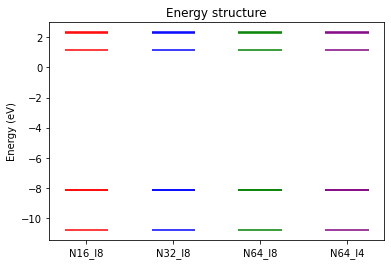

In [5]:
import matplotlib.pyplot as plt

# energy levels
e = {}
for para in ['N16_I8','N32_I8','N64_I8','N64_I4'] :
    e[para] = data['wfreq'][para]['output']['Q']['K000001']['eqpSec']

# plot
x = list(range(1, len(e)+1))
labels = e.keys()

ax = plt.subplot()
for counter, label in enumerate(labels) :
    for a in e[label] :
        ax.hlines(a, x[counter]-0.25, x[counter]+0.25, color=c[label])

plt.title('Energy structure')
plt.xticks(x, labels)
plt.ylabel('Energy (eV)')

plt.show()

We can also compare the timings.

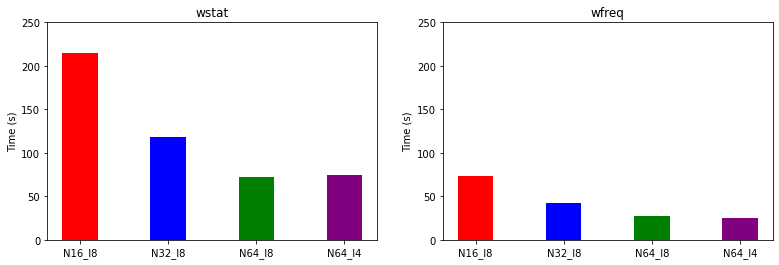

In [6]:
import matplotlib.pyplot as plt

# timings
t = {}
for code in ['wstat','wfreq'] :
    t[code] = {}
    for para in ['N16_I8','N32_I8','N64_I8','N64_I4'] :
        t[code][para] = data[code][para]['timing'][code.upper()]['wall:sec']

# plot
fig = plt.figure(figsize=(13,4))

for icode, code in enumerate(['wstat','wfreq']) :
    x = list(range(1, len(t[code])+1))
    labels = t[code].keys()

    ax = fig.add_subplot(1, 2, icode+1)
    ax.set_title(code)
    ax.set_xticks(x, labels)
    ax.set_ylim(0, 250)
    ax.set_ylabel('Time (s)')

    for counter, label in enumerate(labels) :
        ax.bar(x[counter], t[code][label], width=0.4, color=c[label])

plt.show()

We underline the importance of choosing the parallelization strategy for running large-scale simulations on massively parallel supercomputers. The optimal parameters would of course depend on the specifics of the simulation and the hardware. In general, the image parallelization level is preferred over the other parallelization levels. Using the spin parallelization level usually speeds up calculations of spin-polarized systems. The efficiency of the R&G level of parallelization is largely limited by the efficiency of parallel FFTs.

## 2.3 : Run WEST on GPUs

On the latest release (June 2022) of the [TOP500](https://top500.org/lists/top500/2022/06/) list, 7 of the top 10 supercomputers have GPUs. A GPU device consists of hundreds to thousands of cores that operate at a relatively low frequency and can perform parallel computational tasks in a more energy efficient way than by CPUs. WEST has been ported to NVIDIA GPUs, achieving substantial speedup over its CPU-only version and excellent parallel scalability on over 25,000 GPUs. Using the GPU version of WEST, we carried out some of the largest deterministic full frequency G$_0$W$_0$ calculations performed to date, including an interface model consisting of 10,368 electrons.

For more information about the GPU implementation of WEST, the reader is referred to [J. Chem. Theory Comput. 18, 4690-4707 (2022)](https://doi.org/10.1021/acs.jctc.2c00241).

We will redo the `wstat.x` and `wfreq.x` calculations on 1 [NVIDIA A100 GPU](https://www.nvidia.com/en-us/data-center/a100/).

Open a new terminal, and follow these steps:

**1) ssh to Swing**

```
ssh <username>@swing.lcrc.anl.gov
```

**2) load WEST**
```
module load nvhpc/21.9-4pt64om
module load west/5.2.0
```

**3) download input files**
```
mkdir -p /home/user/MICCoM_School_2022/gpu_swing
cd /home/user/MICCoM_School_2022/gpu_swing
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/H_ONCV_PBE-1.2.upf
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/C_ONCV_PBE-1.2.upf
wget -N -q http://www.west-code.org/doc/training/benzene/pw.in
wget -N -q http://www.west-code.org/doc/training/benzene/wstat.in
wget -N -q http://www.west-code.org/doc/training/benzene/wfreq.in
```

**4) copy the job submission script and submit it**
```
cp /lcrc/project/MICCoM-train/west_tutorial/swing_job_submit .
sbatch swing_job_submit
```

**5) check the status of the job, which should finish in a minute**
```
squeue -u $USER
```

**6) collect the output files**
```
mv benzene.wstat.save/wstat.json ../wstat_N1_G1.json
mv benzene.wfreq.save/wfreq.json ../wfreq_N1_G1.json
```

We compare the quasiparticle energies and timings of the CPU and GPU runs.

In [7]:
import json

# load data
for code in ['wstat','wfreq'] :
    with open(f'{code}_N1_G1.json') as file :
        data[code]['N1_G1'] = json.load(file)

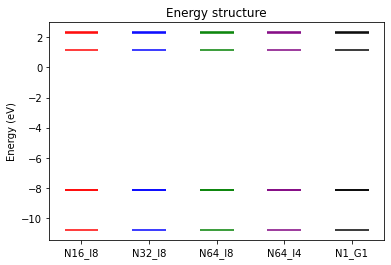

In [8]:
import matplotlib.pyplot as plt

# energy levels
e = {}
for para in ['N16_I8','N32_I8','N64_I8','N64_I4','N1_G1'] :
    e[para] = data['wfreq'][para]['output']['Q']['K000001']['eqpSec']

# plot
x = list(range(1, len(e)+1))
labels = e.keys()

ax = plt.subplot()
for counter, label in enumerate(labels) :
    for a in e[label] :
        ax.hlines(a, x[counter]-0.25, x[counter]+0.25, color=c[label])

plt.title('Energy structure')
plt.xticks(x, labels)
plt.ylabel('Energy (eV)')

plt.show()

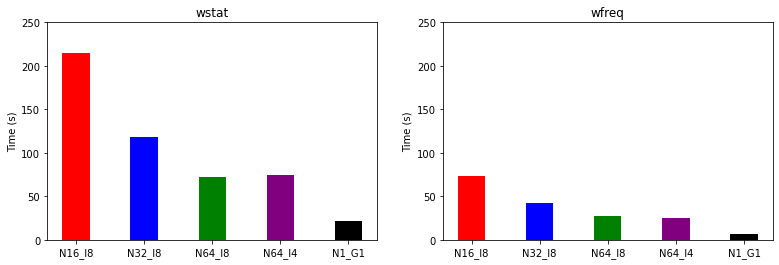

In [9]:
import matplotlib.pyplot as plt

# timings
t = {}
for code in ['wstat','wfreq'] :
    t[code] = {}
    for para in ['N16_I8','N32_I8','N64_I8','N64_I4','N1_G1'] :
        t[code][para] = data[code][para]['timing'][code.upper()]['wall:sec']

# plot
fig = plt.figure(figsize=(13,4))

for icode, code in enumerate(['wstat','wfreq']) :
    x = list(range(1, len(t[code])+1))
    labels = t[code].keys()

    ax = fig.add_subplot(1, 2, icode+1)
    ax.set_title(code)
    ax.set_xticks(x, labels)
    ax.set_ylim(0, 250)
    ax.set_ylabel('Time (s)')

    for counter, label in enumerate(labels) :
        ax.bar(x[counter], t[code][label], width=0.4, color=c[label])

plt.show()

**Question**: *Is the performance on GPU expected?*

Hint: Theoretical double-precision performance of the hardware

- 1 KNL node: 2.7 TFLOPS (10$^{12}$ floating-point operations per second)
- 1 NVIDIA A100 GPU: 9.7 TFLOPS, 19.5 TFLOPS with tensor core